# Deep Q-Network
### Solving `Cartpole_v1` Problem
<center><img src="dqn_buffer.png" alt="DQN with a replay buffer, Ref: Morales" width=500/>

In [1]:
import random
import gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers

<img src="dqn_algorithm_dong.png" alt="DQN Algorithm, Ref: Dong et. al." width=600/>

In [2]:
class DQNAgent:
    def __init__(self, state_size, action_size, alpha):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=1000)
        self.gamma = 0.99
        self.epsilon = 0.1
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999 
        self.learning_rate = alpha 
        self.train_start = 1000
        self.model = self._build_model()

        # Target model  # TODO: Construct target network, set an update frequency, and a counter for updating its weights.
        
    def _build_model(self):
        initializer = initializers.GlorotNormal(seed=42)
        model = Sequential([
            Dense(8, input_dim=self.state_size, activation='relu', kernel_initializer=initializer),
            Dense(16, activation='relu', kernel_initializer=initializer),
            Dense(self.action_size, activation='linear', kernel_initializer=initializer)
        ])
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    # def update_target_network(self):  # TODO: weight updating procedure. Hint: use `set_weights` and `get_weights`
    #     # One line of code missing!
        
    def act(self, state):
        if np.random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            q_values = self.model.predict(state, verbose=0)
            return np.argmax(q_values[0])
    
    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return []

        minibatch = random.sample(self.memory, batch_size)
        batch_loss = []

        current_state = np.zeros((batch_size, self.state_size))
        next_state = np.zeros((batch_size, self.state_size))
        action, reward, done = [], [], []

        for i in range(batch_size):
            current_state[i] = minibatch[i][0]
            action.append(minibatch[i][1])
            reward.append(minibatch[i][2])
            next_state[i] = minibatch[i][3]
            done.append(minibatch[i][4])

        # Standard DQN update
        target_q = self.model.predict(current_state, verbose=0)
        next_q_values = self.model.predict(next_state, verbose=0)

        for i in range(batch_size):
            if done[i]:
                target_q[i][action[i]] = reward[i]
            else:
                target_q[i][action[i]] = reward[i] + self.gamma * np.max(next_q_values[i])

        self.model.fit(current_state, target_q, batch_size=batch_size, epochs=1, verbose=0)
        batch_loss.append(-0.1) # TODO: extract loos and replace it with -0.1

        if (self.epsilon > self.epsilon_min) and \
             (len(self.memory) >= self.train_start):
                self.epsilon *= self.epsilon_decay

        # Update target network  # TODO: time to call `update_target_network()`?
        # 3 lines of code missing!
        # 
        # 

        return batch_loss

## Target network
<center><img src="q-target-01.png" alt="Q-function optimization without a target network" width=400/>

<center><img src="q-target-02.png" alt="Q-function approximation with a target network" width=400/>

> **TODO:** Add a target network to the DQN scheme.

In [3]:
def single_run(alpha=0.01, N=500):
    env = gym.make('CartPole-v1')
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n 
    agent = DQNAgent(state_size, action_size, alpha)

    episode_lengths = np.zeros(shape=(N,))
    mse_per_episode = np.zeros(shape=(N,))
    scores = []
    
    batch_size = 64
    max_steps = 200
    
    for episode in range(N):
        state, _ = env.reset()
        state = np.reshape(state, [1, state_size])        # Reshape state for NN      
        steps = 0
        
        while steps < max_steps:
            # Select and perform action
            action = agent.act(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            next_state = np.reshape(next_state, [1, state_size])            # Reshape state for NN

            # Modified reward structure
            done = terminated or truncated
            reward = reward if not done else -100 ############### TODO: experiment with and without this modified reward structure
            
            # Store transition
            agent.remember(state, action, reward, next_state, done)
            
            # Move to next state
            state = next_state
            steps += 1
            
            # Perform batch training if enough samples
            if len(agent.memory) > batch_size:
                batch_loss = agent.replay(batch_size)
            
            if done:
                break
        
        # Store episode results
        episode_lengths[episode] = steps
        mse_per_episode[episode] = -0.1 ## TODO: Store and log MSE of the episode
        scores.append(reward)
        
        # Logging
        if (episode + 1) % 10 == 0:
            print(f"Episode: {episode + 1:4d} | "
                  f"Score: {steps:4d} | "
                  f"Epsilon: {agent.epsilon:.2f} | "
                  f"Memory: {len(agent.memory):5d} | "
                  f"MSE: {mse_per_episode[episode]:.2f}")

    return agent, scores, episode_lengths, mse_per_episode

> **TODO:** Make the results more reproducible (Hint: seed everything; i.e., gym's env, keras's initial NN weights, and random number generators)

In [4]:
n_episodes = 50
alph1 = 'lr=0.001'
alph2 = 'lr=0.002'

In [5]:
%%time

model1, reward_hist_tot1, ep_length_tot1, mse_per_episode_tot1 = single_run(alpha=0.001, N=n_episodes)

Episode:   10 | Score:   24 | Epsilon: 0.10 | Memory:   165 | MSE: 295.14
Episode:   20 | Score:   43 | Epsilon: 0.10 | Memory:   866 | MSE: 85.26
Episode:   30 | Score:   90 | Epsilon: 0.05 | Memory:  1000 | MSE: 51.49
Episode:   40 | Score:   42 | Epsilon: 0.03 | Memory:  1000 | MSE: 50.43
Episode:   50 | Score:   38 | Epsilon: 0.02 | Memory:  1000 | MSE: 27.41
CPU times: total: 7min 52s
Wall time: 14min 2s


In [6]:
%%time

model2, reward_hist_tot2, ep_length_tot2, mse_per_episode_tot2 = single_run(alpha=0.002, N=n_episodes)

Episode:   10 | Score:   52 | Epsilon: 0.10 | Memory:   202 | MSE: 231.55
Episode:   20 | Score:   42 | Epsilon: 0.10 | Memory:   915 | MSE: 45.10
Episode:   30 | Score:  162 | Epsilon: 0.04 | Memory:  1000 | MSE: 17.43
Episode:   40 | Score:   16 | Epsilon: 0.01 | Memory:  1000 | MSE: 115.18
Episode:   50 | Score:   13 | Epsilon: 0.01 | Memory:  1000 | MSE: 421.14
CPU times: total: 9min 10s
Wall time: 17min 31s


> **TODO:** Experiment with the modified reward structure

## Learning curves

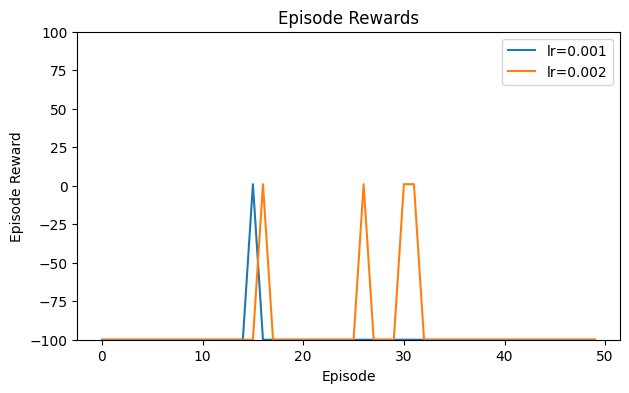

In [12]:
# Episode Reward vs. Episode
plt.figure(figsize=(7, 4))
plt.plot(reward_hist_tot1, label=alph1)
plt.plot(reward_hist_tot2, label=alph2)
plt.xlabel('Episode')
plt.ylabel('Episode Reward')
plt.title('Episode Rewards')
plt.legend()
plt.ylim(-100, 100)
plt.show()

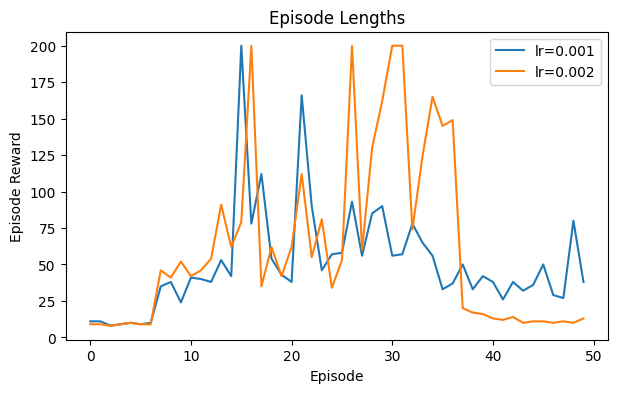

In [13]:
# Episode Length vs. Episode
plt.figure(figsize=(7, 4))
plt.plot(ep_length_tot1, label=alph1)
plt.plot(ep_length_tot2, label=alph2)
plt.xlabel('Episode')
plt.ylabel('Episode Reward')
plt.title('Episode Lengths')
plt.legend()
# plt.ylim(-200, 15)
plt.show()

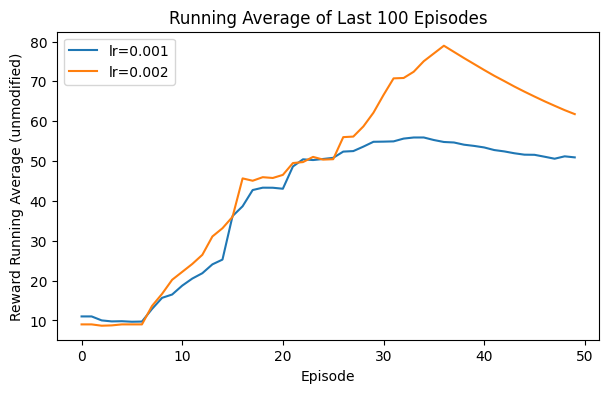

In [16]:
def plot_running_avg(totalrewards1,totalrewards2):
    N = len(totalrewards1)
    totalrewards1 = np.array(totalrewards1)
    totalrewards2 = np.array(totalrewards2)
    running_avg1 = np.empty(N)
    running_avg2 = np.empty(N)
    for t in range(N):
        running_avg1[t] = totalrewards1[max(0, t-100):(t+1)].mean()
        running_avg2[t] = totalrewards2[max(0, t-100):(t+1)].mean()
    plt.figure(figsize=(7, 4))
    plt.plot(running_avg1, label=alph1)
    plt.plot(running_avg2, label=alph2)
    plt.xlabel('Episode')
    plt.ylabel('Reward Running Average (unmodified)')
    plt.title("Running Average of Last 100 Episodes")
    plt.legend()
    plt.show()
    
plot_running_avg(ep_length_tot1,ep_length_tot2)

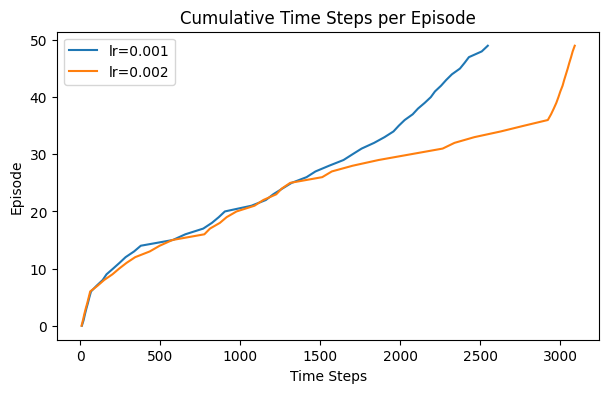

In [17]:
cumulative_steps1 = np.cumsum(ep_length_tot1)
cumulative_steps2 = np.cumsum(ep_length_tot2)

# Cumulative Time Steps vs. Episode
plt.figure(figsize=(7, 4))
plt.plot(cumulative_steps1[0:len(reward_hist_tot1)], range(len(reward_hist_tot1)), label=alph1)
plt.plot(cumulative_steps2[0:len(reward_hist_tot2)], range(len(reward_hist_tot2)), label=alph2)
plt.ylabel('Episode')
plt.xlabel('Time Steps')
plt.title('Cumulative Time Steps per Episode')
plt.legend()
plt.show()

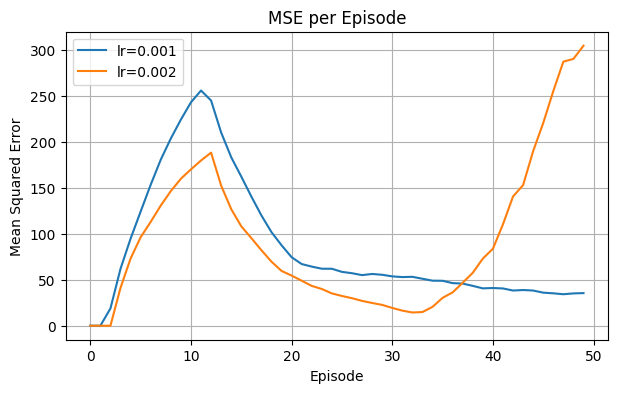

In [18]:
from scipy.ndimage import uniform_filter

mse_per_episode_avg1 = uniform_filter(mse_per_episode_tot1, size=10)
mse_per_episode_avg2 = uniform_filter(mse_per_episode_tot2, size=10)

# MSE vs. Episode
plt.figure(figsize=(7, 4))
plt.plot(mse_per_episode_avg1[0:len(reward_hist_tot1)], label=alph1)
plt.plot(mse_per_episode_avg2[0:len(reward_hist_tot1)], label=alph2)
plt.xlabel('Episode')
plt.ylabel('Mean Squared Error')
plt.title('MSE per Episode')
plt.legend()
plt.grid(True)
# plt.ylim(0, 100)
plt.show()

> **TODO:** Plot batch loss per epoch

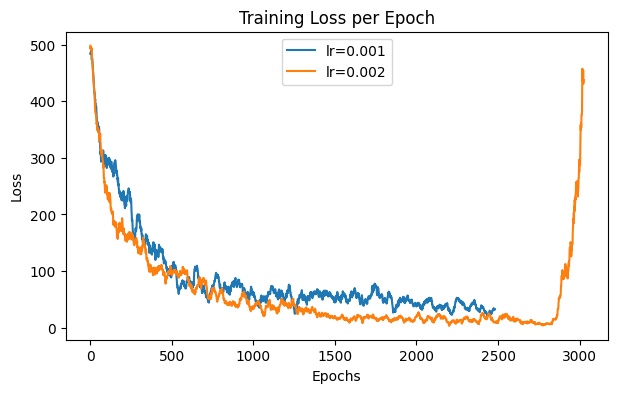

In [20]:
loss_hist1 = ## TODO: Extract loss
loss_hist2 = ## TODO: Extract loss

plt.figure(figsize=(7, 4))
plt.plot(loss_hist1, label=alph1)
plt.plot(loss_hist2, label=alph2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()
plt.show()

## State histogram

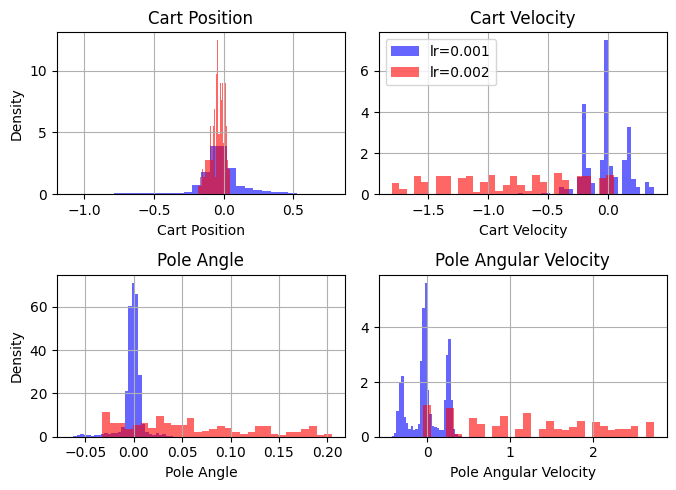

In [11]:
# TODO